<!--NOTEBOOK_HEADER-->
*This notebook contains material from [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook);
content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# 6.4 Soft Landing Falcon 9

Keywords: optimal control, ipopt usage, dae, differential-algebraic equations, rescaling time

This notebook can be used to generate the batch of optimal trajectories used to train the neural network by imitation learning.

## 6.4.1 Imports

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -y -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

%pip install ipywidgets
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from ipywidgets import IntProgress
from IPython.display import display

## 6.4.2 Version 1: Vertical dynamics of a rocket with constant mass

For a rocket with a mass $m$ in vertical flight at altitude $h$, a momentum balance yields the model

\begin{align*}
m\frac{d^2y}{dt^2} & = - m g + T_{max}u\sin(\theta+\delta) \\
m\frac{d^2x}{dt^2} & = T_{max}u\cos(\theta+\delta) \\
J\frac{d^2\theta}{dt^2} & = -T_{max}u\sin(\delta)(x_{T}-x_{CG}) \\
\end{align*}

where $u\in[0,1]$ is the normalized thrust and $T_{max}$ is the engine maximum thrust. For the rotational balance $J$ is the inertia of the rocket and the quantity $(x_{T}-x_{CG})$ is the distance between the center of mass of the rocket and the engine gimbal attachment (where the thrust is transfered to the body of the launcher), both measured from the tip of the rocket.

In this first attempt at modeling and control we will neglect the change in rocket mass due to fuel burn.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/LM_illustration_02-IT.png/368px-LM_illustration_02-IT.png)

<a title="LM_illustration_02.jpg: NASA Marshall Space Flight Center (NASA-MSFC)
derivative work: Adert [Public domain], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:LM_illustration_02-IT.png"></a>

LM_illustration_02.jpg: NASA Marshall Space Flight Center (NASA-MSFC)derivative work: Adert [Public domain]

The following data is for the [Falcon 9 rocket](https://www.spacex.com/media/falcon-users-guide-2021-09.pdf).

In [19]:
# lunar module
m_total = 50000                 # kg
I_total = 6.04e6                # kg*m**2
L_thrust = 30                   # Thrust arm [m]

# descent engine characteristics
u_max = 981600                  # 981.6 kNewtons

# landing mission specifications
h_initial = 1000.0           # meters
x_initial = 100
theta_initial = np.pi/2.        # Initial angle from vertical

vy_initial = -300               # falling velocity m/s
vx_initial = 0               # horizontal velocity m/s
vtheta_initial = 0

g = 9.81                     # m/s**2

deg_to_rad = np.pi/180

## 6.4.3 Version 2: Rescaled model

At this point, it's now clear the first version of this model has run into some serious problems:

* The calculated trajectory takes us through a crash landing and trip through the interior of the moon. 
* The engine thrust never goes to zero, even when the lander is at zero velocity and on the surface. The reason is that the model doesn't account for the reaction force of the surface on the lander. So the lander is really just hoovering rather than landing.
* There is no obvious means of estimating the time required for the mission. 

Let's begin with the last issue. We will introduce an additional decision variable $T$ denoting the length of the mission. Time is then rescaled as

$$\tau = \frac{t}{T}\quad\implies\quad t =\tau T$$

The differential equation model then becomes

\begin{align*}
\frac{m}{T^2}\frac{d^2h}{d\tau^2} & = - m g + v_eu \\
\end{align*}

The net result is that an additional variable, $T$, denoting the duration of the descent mission has been introduced into the optimization problem.

In [20]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, 1))
m.y = Var(m.t)
m.x = Var(m.t)
m.theta = Var(m.t)
m.u = Var(m.t, bounds=(0, 1))
m.gimbal = Var(m.t, bounds=(-20*deg_to_rad, +20*deg_to_rad))
m.T = Var(domain=NonNegativeReals)

m.vx = DerivativeVar(m.x, wrt=m.t)
m.vy = DerivativeVar(m.y, wrt=m.t)
m.vtheta = DerivativeVar(m.theta, wrt=m.t)

m.ax = DerivativeVar(m.vx, wrt=m.t)
m.ay = DerivativeVar(m.vy, wrt=m.t)
m.atheta = DerivativeVar(m.vtheta, wrt=m.t)

# Dynamics constraints definition (EOM)
m.ode1 = Constraint(m.t, rule = lambda m, t: 
    m_total*m.ax[t]/m.T**2 == u_max*m.u[t]*cos(m.gimbal[t]+m.theta[t]))

m.ode2 = Constraint(m.t, rule = lambda m, t: 
    m_total*m.ay[t]/m.T**2 == u_max*m.u[t]*sin(m.gimbal[t]+m.theta[t]) - m_total*g)

m.ode3 = Constraint(m.t, rule = lambda m, t: 
    I_total*m.atheta[t]/m.T**2 == -L_thrust*u_max*m.u[t]*sin(m.gimbal[t]))

m.y[0].fix(h_initial)
m.x[0].fix(x_initial)
m.theta[0].fix(theta_initial)

m.vy[0].fix(vy_initial)
m.vx[0].fix(vx_initial)
m.vtheta[0].fix(vtheta_initial)

m.y[1].fix(0)    # land on surface
m.x[1].fix(0)    # land on surface
m.theta[1].fix(np.pi/2)    # land on surface

m.vx[1].fix(0)    # soft landing
m.vy[1].fix(0)    # soft landing
m.vtheta[1].fix(0)    # soft landing


### 6.4.3.1 Minimize fuel consumption

$$\min_{u(\tau), T} T\int_0^1 u(\tau)\, d\tau$$

In [21]:

# Minimum fuel constraint
m.fuel = Integral(m.t, wrt=m.t, rule = lambda m, t: m.u[t]*m.T)
m.obj = Objective(expr=m.fuel, sense=minimize)

def solve(m):
  
    TransformationFactory('dae.finite_difference').apply_to(m, nfe=150, scheme='FORWARD')
    SolverFactory('ipopt').solve(m)
    
solve(m)

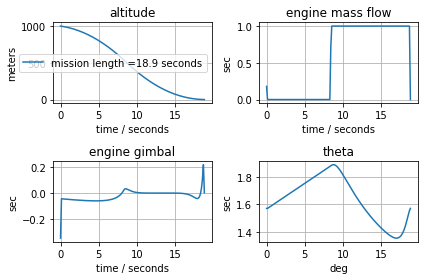

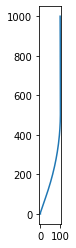

In [22]:
def plot(m):
    tsim = [t*m.T() for t in m.t]
    hsim = [m.y[t]() for t in m.t]
    thetasim = [m.theta[t]() for t in m.t]
    usim = [m.u[t]() for t in m.t]
    gimbalsim = [m.gimbal[t]() for t in m.t]

    plt.subplot(2,2,1)
    plt.plot(tsim, hsim)
    plt.title('altitude')
    plt.xlabel('time / seconds')
    plt.ylabel('meters')
    plt.legend(['mission length =' + str(round(m.T(),1)) + ' seconds'])
    plt.grid(True)
    
    plt.subplot(2,2,2)
    plt.plot(tsim, usim)
    plt.title('engine mass flow')
    plt.xlabel('time / seconds')
    plt.ylabel('sec')
    plt.grid(True)
    
    plt.subplot(2,2,3)
    plt.plot(tsim, gimbalsim)
    plt.title('engine gimbal')
    plt.xlabel('time / seconds')
    plt.ylabel('sec')
    plt.grid(True)

    plt.subplot(2,2,4)
    plt.plot(tsim, thetasim)
    plt.title('theta')
    plt.xlabel('deg')
    plt.ylabel('sec')
    plt.grid(True)
    
    plt.tight_layout()

def plot_trajectory(m):
    tsim = [t*m.T() for t in m.t]
    ysim = [m.y[t]() for t in m.t]
    xsim = [m.x[t]() for t in m.t]

    __,ax, = plt.subplots()
    plt.plot(xsim,ysim)
    ax.set_aspect('equal')
    plt.show()

plot(m)
plot_trajectory(m)

Generate an animation of the landing

Code from: [https://medium.com/analytics-vidhya/dynamic-optimization-in-python-rocket-soft-landing-a5a68eaf3b94]

Generating Animation


IntProgress(value=0, max=152)

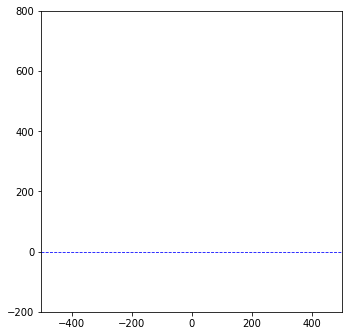

In [23]:
print("Generating Animation")
steps = len([t for t in m.t]) + 1
final_time_step = round(1/steps,2)
f = IntProgress(min = 0, max = steps)
display(f)

xsim = np.array([m.x[t]() for t in m.t]).reshape(-1,1)
vxsim = np.array([m.vx[t]() for t in m.t]).reshape(-1,1)
ysim = np.array([m.y[t]() for t in m.t]).reshape(-1,1)
vysim = np.array([m.vy[t]() for t in m.t]).reshape(-1,1)
theta_sim = np.array([m.theta[t]() for t in m.t]).reshape(-1,1)
vtheta_sim = np.array([m.vtheta[t]() for t in m.t]).reshape(-1,1)

thrust_sim = np.array([m.u[t]() for t in m.t]).reshape(-1,1)
thrust_angle_sim = np.array([m.gimbal[t]() for t in m.t]).reshape(-1,1)

x_t = np.hstack([xsim,vxsim,ysim,vysim,theta_sim,vtheta_sim])
u_t = np.hstack([thrust_sim,thrust_angle_sim])

fig = plt.figure(figsize = (5,8), constrained_layout=False)
ax1 = fig.add_subplot(111)
plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato') # thrust line
ln1, = ax1.plot([], [], linewidth = 7, color = 'lightblue') # rocket body

plt.tight_layout()

ax1.set_xlim(-500, 500)
ax1.set_ylim(-200, 800)
ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

# Size
length = 50                       # m
width = 3.66                         # m

def update(i):
    rocket_theta = x_t[i, 4] +np.pi/2

    rocket_x = x_t[i, 0]
    # length/1 is just to make rocket bigger in animation
    rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

    rocket_y = x_t[i, 2]
    rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

    ln1.set_data(rocket_x_points, rocket_y_points)

    thrust_mag = u_t[i, 0]*u_max
    thrust_angle = -u_t[i, 1]
    v_exhaust=3000
    flame_length = (thrust_mag) * (0.4/v_exhaust)
    flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle + rocket_theta)]
    flame_y_points = [rocket_y_points[1], rocket_y_points[1] + flame_length * np.cos(thrust_angle + rocket_theta)]

    ln2.set_data(flame_x_points, flame_y_points)
    ln6.set_data(x_t[:i, 0], x_t[:i, 2])

    f.value += 1

playback_speed = 6500 # the higher the slower 
anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

anim
writergif = PillowWriter(fps=30) 

anim.save(os.getcwd()+'/optimal_lander.gif', writer=writergif)

## 6.4.4 Version 3: Rocket model

The first version of the rocket model has run into a serious problem because it appears not to provide enough mass flow to the engine to prevent a crash landing. But that may be an artifact of the assumption of constant mass. For Apollo 11 Lunar Module, for example, the fuel in the descent engine comprises more than 50% of the total mass of the lander.

For the second version of the rocket model, we augment the model with a mass balance for fuel. This yields 

\begin{align*}
\frac{m(t)}{T^2}\frac{d^2h}{d\tau^2} & = - m(t)g + v_eu \\
\\
\frac{1}{T}\frac{dm}{d\tau} & = -u
\end{align*}

At this point we need to worry about nonsensical answers to the optimization for minimum fuel. For this purpose we add upper and lower bounds on $T$ that should restrict the solver to meaningful solutions.

In [24]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, 1))
m.h = Var(m.t, domain=NonNegativeReals)
m.m = Var(m.t)
m.u = Var(m.t, bounds=(0, u_max))
m.T = Var(bounds=(50,3000))

m.v = DerivativeVar(m.h, wrt=m.t)
m.a = DerivativeVar(m.v, wrt=m.t)
m.mdot = DerivativeVar(m.m, wrt=m.t)

m.fuel = Integral(m.t, wrt=m.t, rule = lambda m, t: m.u[t]*m.T)
m.obj = Objective(expr=m.fuel, sense=minimize)

m.ode1 = Constraint(m.t, rule = lambda m, t: m.m[t]*m.a[t]/m.T**2 == -m.m[t]*g + v_exhaust*m.u[t])
m.ode2 = Constraint(m.t, rule = lambda m, t: m.mdot[t]/m.T == -m.u[t])

m.h[0].fix(h_initial)
m.v[0].fix(-v_initial)
m.m[0].fix(m_total)

m.h[1].fix(0)    # land on surface
m.v[1].fix(0)    # soft landing

def solve(m):
    TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, scheme='FORWARD')
    SolverFactory('ipopt').solve(m)

    m_nonfuel = m_ascent_dry + m_ascent_fuel + m_descent_dry
    
    tsim = [t*m.T() for t in m.t]
    hsim = [m.h[t]() for t in m.t]
    usim = [m.u[t]() for t in m.t]
    fsim = [m.m[t]() - m_nonfuel for t in m.t]

    plt.figure(figsize=(8,6))
    plt.subplot(3,1,1)
    plt.plot(tsim, hsim)
    plt.title('altitude')
    plt.ylabel('meters')
    plt.legend(['mission length = ' + str(round(m.T(),1)) + ' seconds'])
    plt.grid(True)

    plt.subplot(3,1,2)
    plt.plot(tsim, usim)
    plt.title('engine mass flow')
    plt.ylabel('kg/sec')
    plt.legend(['fuel burned = ' + str(round(m.fuel(),1)) + ' kg'])
    plt.grid(True)

    plt.subplot(3,1,3)
    plt.plot(tsim, fsim)
    plt.title('fuel remaining')
    plt.xlabel('time / seconds')
    plt.ylabel('kg')
    plt.legend(['fuel remaining = ' + str(round(fsim[-1],2)) + ' kg'])
    plt.grid(True)

    plt.tight_layout()

solve(m)

ERROR: Rule failed when generating expression for Constraint ode1 with index
    0: NameError: name 'v_exhaust' is not defined
ERROR: Constructing component 'ode1' from data=None failed: NameError: name
    'v_exhaust' is not defined


NameError: name 'v_exhaust' is not defined